In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
import matplotlib.pyplot as plt

# Carga de datos

En primer lugar, cargamos los datos proporcionados y visualizamos las variables de las que disponemos.

In [2]:
df = pd.read_excel('../data/Handball Woman European Data Set.xlsx', index_col=0)

In [3]:
df.tail(6)

,Phase,Match,Team,No,Name,Goals,Shots,%,7m%,7mPGoals,7mPMissed,6mCGoals,6mCMissed,WingGoals,WingMissed,BTGoals,BTMissed,FBGoals,FBMissed,FTOGoals,FTOMissed,9mGoals,9mMissed,YC,RC,2M,2+2,AS,R7,ST,BS,P7,TO,Time,scoring,MVP
1494,FINAL,FRA-NOR,NOR,13,DALE Kari,1,1,100,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,60.000000,0.2,0
1495,FINAL,FRA-NOR,NOR,16,LUNDE Katrine,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.283333,0.0,0
1496,FINAL,FRA-NOR,NOR,20,JACOBSEN Marit,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.0,0
1497,FINAL,FRA-NOR,NOR,23,HERREM Camilla,3,4,75,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,37.000000,3.1,0
1498,FINAL,FRA-NOR,NOR,24,SOLBERG-ISAKSEN Sanna Charlotte,1,2,50,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23.000000,0.3,0
1499,FINAL,FRA-NOR,NOR,25,BREISTOL Kristine,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.0,0


In [4]:
df.dtypes

Phase          object
Match          object
Team           object
No              int64
Name           object
Goals           int64
Shots           int64
%               int64
7m%             int64
7mPGoals        int64
7mPMissed       int64
6mCGoals        int64
6mCMissed       int64
WingGoals       int64
WingMissed      int64
BTGoals         int64
BTMissed        int64
FBGoals         int64
FBMissed        int64
FTOGoals        int64
FTOMissed       int64
9mGoals         int64
9mMissed        int64
YC              int64
RC              int64
2M              int64
2+2             int64
AS              int64
R7              int64
ST              int64
BS              int64
P7              int64
TO              int64
Time          float64
scoring       float64
MVP             int64
dtype: object

# Clustering inicial

Realizamos una aproximación inicial utilizando los datos agregados con todos los goles y lanzamientos. Agrupamos los datos de esas dos variables por equipos.

In [181]:
simplified_df = df[['Team', 'Goals', 'Shots']]
# Agrupamos por equipo y sumamos las estadísticas de cada uno
teams_df = simplified_df.groupby('Team').sum().reset_index()
teams_df

,Team,Goals,Shots
0,CRO,193,339
1,CZE,69,134
2,DEN,209,353
3,ESP,147,261
4,FRA,209,342
5,GER,145,284
6,HUN,156,291
7,MNE,148,262
8,NED,193,356
9,NOR,254,400


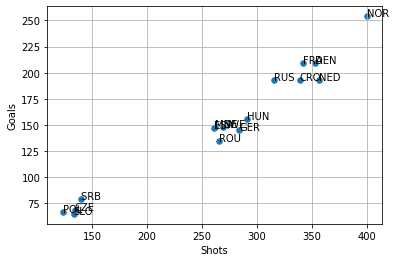

In [182]:
X = teams_df[['Shots', 'Goals']]

plt.scatter(X['Shots'], X['Goals'], s=30)
plt.xlabel('Shots')
plt.ylabel('Goals')
plt.grid()

ax = plt.gca()
for i in range(0,len(teams_df)):
    ax.annotate(teams_df.iloc[i,:]['Team'], (X.iloc[i,0], X.iloc[i,1]))

plt.show()

Aplicamos Expectation-Maximization (EM). Para saber cuáles son los parámetros óptimos, buscamos cuál es el BIC menor para distintas configuraciones.

In [197]:
from sklearn.mixture import GaussianMixture

cv_types = ['spherical', 'tied', 'diag', 'full']
n_components_range = range(1, 10)

BIC = []
lowest_bic = np.infty
best_cv = 'full'
best_k = -1

for cv_type in cv_types:
    for k in n_components_range:
        EM = GaussianMixture(n_components=k, covariance_type=cv_type, init_params='random')
        EM.fit(X)
        
        BIC.append(EM.bic(X))
        
        if BIC[-1] < lowest_bic:
            lowest_bic = BIC[-1]
            best_cv = cv_type
            best_k = k
            
print("Mejor valor K:", best_k)
print("Mejor tipo de Covarianza:", best_cv)

Mejor valor K: 8
Mejor tipo de Covarianza: spherical


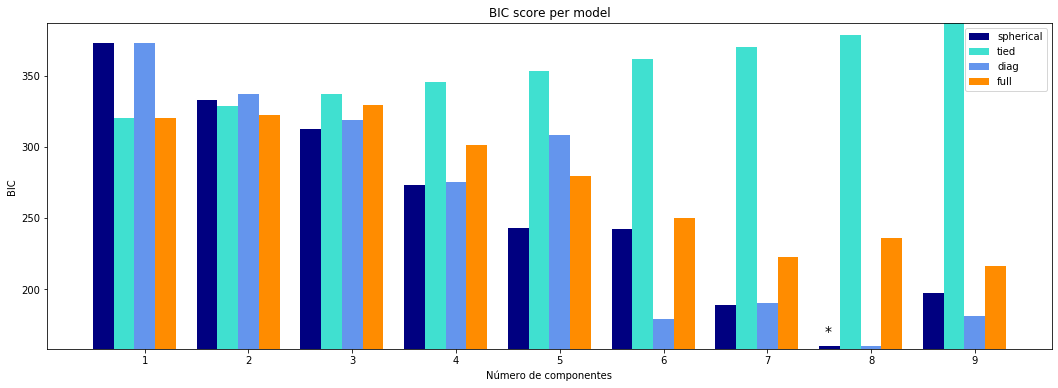

In [198]:
import itertools
import matplotlib.pyplot as plt

color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue', 'darkorange'])

plt.figure(figsize=(18, 6))
bars = []
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos,
                        BIC[i * len(n_components_range):(i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([min(BIC) * 1.01 - .01 * max(BIC), max(BIC)])

plt.title('BIC score per model')
plt.xlabel('Número de componentes')
plt.ylabel('BIC')
plt.legend([b[0] for b in bars], cv_types)

xpos = np.mod(np.argmin(BIC), len(n_components_range)) + .55 + .2 * np.floor(np.argmin(BIC) / len(n_components_range))
plt.text(xpos, min(BIC) * 0.97 + .03 * max(BIC), '*', fontsize=14)

plt.show()

El BIC indica que el mejor número de clústers es 8-9, pero al visualizar los datos vemos que parece haber 4 grupos. Esto puede deberse a que este algoritmo tiende mucho al sobreaprendizaje y le cuesta mucho encontrar las mejores distribuciones.

Debido a eso, vamos a ejecutarlo con 4 clústers en lugar de 8 basándonos en nuestra opinión.

In [221]:
EM = GaussianMixture(n_components=4, covariance_type='spherical', init_params='kmeans')
EM.fit(X)
labels =  EM.predict(X)

Definimos una función de utilidad para pintar el resultado del EM con los círculos representando las gausianas. Se usará también más adelante.

In [218]:
import itertools
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt

from matplotlib.patches import Ellipse
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap

def plot_EM(model, X, grid=False, labels=None, out=None):
    if labels is None:
        # Calculamos las agrupaciones si no estaban hechas
        labels = model.fit(X).predict(X)
    
    ax = plt.gca()
    clusters = np.unique(labels)
    
    norm = Normalize(vmin=0, vmax=len(clusters)-1)
    cmap = get_cmap('viridis')
    # Pintamos los puntos de cada clúster
    # Lo hacemos separado para poder mostrar la leyenda con el número de clúster
    for cluster_index in clusters:
        ax.scatter(
            X.loc[labels == cluster_index].iloc[:,0],
            X.loc[labels == cluster_index].iloc[:,1],
            c=[cmap(norm(cluster_index))],
            label=cluster_index,
            s=40,
            zorder=2)
    #ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    ax.legend()
    
    for i in range(0,len(teams_df)):
        ax.annotate(teams_df.iloc[i,:]['Team'], (X.iloc[i,0], X.iloc[i,1]))
    
    w_factor = 0.2 / model.weights_.max()
    for pos, covar, w in zip(model.means_, model.covariances_, model.weights_):
        if covar.shape == (2, 2):
            U, s, Vt = np.linalg.svd(covar)
            angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
            width, height = 2 * np.sqrt(s)
        elif covar.shape == (2,):
            angle = 0
            width, height = 2 * np.sqrt(covar)
        else:
            angle = 0
            width = height = 2 * np.sqrt(covar)
    
        # Draw the Ellipse
        for nsig in range(1, 4):
            ax.add_patch(Ellipse(pos, nsig * width, nsig * height, angle, alpha=w * w_factor))
    
    if grid:
        plt.grid()
        
    if out is not None:
        plt.savefig(out)
        
    plt.show()

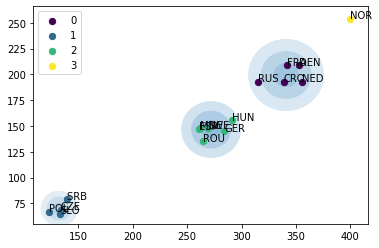

In [224]:
plot_EM(EM, X)
#plot_EM(EM, X, out='../figures/Hito2_analisis-exploratorio.pdf')

In [225]:
teams_df['cluster'] = labels

grouped_teams = teams_df[['Team', 'cluster']].groupby('cluster')['Team'].apply(list)
grouped_teams

cluster
0         [CRO, DEN, FRA, NED, RUS]
1             [CZE, POL, SLO, SRB ]
2    [ESP, GER, HUN, MNE, ROU, SWE]
3                             [NOR]
Name: Team, dtype: object

# Variables significativas y limpieza de datos

Este análisis es muy similar al que se hizo para las jugadoras.

In [48]:
for column in df:
    if column in ['Phase', 'Match', 'Team', 'No', 'Name', '%', '7m%', 'YC', 'Time', 'scoring', 'MVP']:
        continue
    print(column, ':', sorted(df[column].unique()))

Goals : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Shots : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 19]
7mPGoals : [0, 1, 2, 3, 4, 5, 6, 8, 9]
7mPMissed : [0, 1, 2]
6mCGoals : [0, 1, 2, 3, 4, 5, 6]
6mCMissed : [0, 1, 2, 3]
WingGoals : [0, 1, 2, 3, 4, 5, 6]
WingMissed : [0, 1, 2, 3, 4]
BTGoals : [0, 1, 2, 3, 4]
BTMissed : [0, 1, 2, 4]
FBGoals : [0, 1, 2, 3, 4, 6]
FBMissed : [0, 1, 2, 3]
FTOGoals : [0, 1]
FTOMissed : [0, 1]
9mGoals : [0, 1, 2, 3, 4, 5, 6, 7]
9mMissed : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
RC : [0, 1]
2M : [0, 1, 2, 3]
2+2 : [0]
AS : [0, 1, 2, 3, 4, 5, 6, 7]
R7 : [0, 1, 2, 3, 4]
ST : [0, 1, 2, 3, 4, 5]
BS : [0, 1, 2, 3, 4, 5, 7]
P7 : [0, 1, 2, 3, 4]
TO : [0, 1, 2, 3, 4, 5, 6, 7, 8]


In [95]:
# ['Phase','Match','Team','No','Name','Goals','Shots','%','7m%','7mPGoals','7mPMissed','6mCGoals','6mCMissed','WingGoals','WingMissed','BTGoals','BTMissed','FBGoals','FBMissed','FTOGoals','FTOMissed','9mGoals','9mMissed','YC','RC','2M','2+2','AS','R7','ST','BS','P7','TO','Time','scoring','MVP']

valid_cols = ['Team','7mPGoals','7mPMissed','6mCGoals','6mCMissed','WingGoals','WingMissed','BTGoals','BTMissed','FBGoals','FBMissed','FTOGoals','FTOMissed','9mGoals','9mMissed','RC','2M','AS','R7','ST','BS','P7','TO']
valid_cols_df = df[valid_cols]

print(valid_cols_df.shape)
valid_cols_df.dtypes

(1500, 23)


Team          object
7mPGoals       int64
7mPMissed      int64
6mCGoals       int64
6mCMissed      int64
WingGoals      int64
WingMissed     int64
BTGoals        int64
BTMissed       int64
FBGoals        int64
FBMissed       int64
FTOGoals       int64
FTOMissed      int64
9mGoals        int64
9mMissed       int64
RC             int64
2M             int64
AS             int64
R7             int64
ST             int64
BS             int64
P7             int64
TO             int64
dtype: object

## Procesado de datos

Agrupamos los datos por equipos, agregando todos sus datos.

In [96]:
teams_df = valid_cols_df.groupby('Team').sum().reset_index()

print(teams_df.shape)
teams_df

(16, 23)


,Team,7mPGoals,7mPMissed,6mCGoals,6mCMissed,WingGoals,WingMissed,BTGoals,BTMissed,FBGoals,FBMissed,FTOGoals,FTOMissed,9mGoals,9mMissed,RC,2M,AS,R7,ST,BS,P7,TO
0,CRO,16,7,49,12,41,32,20,4,10,7,0,0,57,84,2,28,96,25,33,15,42,98
1,CZE,8,5,4,3,22,10,5,3,5,4,0,0,25,40,0,10,22,13,12,3,24,40
2,DEN,20,7,23,15,75,39,21,5,22,7,3,0,45,71,0,25,94,27,39,29,32,84
3,ESP,26,5,24,16,50,39,5,11,16,7,1,1,25,35,1,24,83,31,24,10,21,94
4,FRA,21,11,36,24,56,34,17,4,38,12,0,0,41,48,1,26,90,32,55,20,34,96
5,GER,15,12,24,12,32,27,22,14,20,11,0,0,32,63,0,27,76,27,26,13,30,72
6,HUN,17,6,14,10,46,36,25,13,19,6,0,2,35,62,0,13,80,24,23,11,25,79
7,MNE,20,3,25,5,44,47,4,6,20,7,0,2,35,44,0,17,77,23,28,8,20,77
8,NED,21,7,29,8,51,49,23,16,28,13,0,2,41,68,0,22,105,28,34,15,23,81
9,NOR,35,9,36,14,59,40,44,15,47,18,0,0,33,50,0,18,148,44,34,33,24,75


# Outliers

Al igual que con las jugadoras, se utilizará el método Jackknife.

In [51]:
from sklearn.cluster import KMeans

K = 5
values_df = teams_df.drop('Team', 1)
SSE = []

N = len(teams_df)
for i in range(N):
    X = values_df.drop(i)
    
    km = KMeans(K, 'random', n_init=10, max_iter=300, tol=1e-04, random_state=0)
    distances = km.fit_transform(X) # Distancias de cada punto a cada clúster
    distances = np.min(distances, axis=1) # Distancias de cada punto a su clúster (el más cercano, mínima distancia)
    
    SSE.append((distances**2).sum())

Outliers found at: []


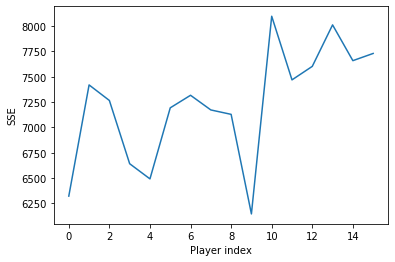

,Team,7mPGoals,7mPMissed,6mCGoals,6mCMissed,WingGoals,WingMissed,BTGoals,BTMissed,FBGoals,FBMissed,FTOGoals,FTOMissed,9mGoals,9mMissed,RC,2M,AS,R7,ST,BS,P7,TO


In [52]:
sigma = np.std(SSE)
mu = np.mean(SSE)
umbral = 3
outliers = []
for i in range(N):
    if abs(SSE[i] - mu) > umbral * sigma:
        outliers.append(i)

print('Outliers found at:', outliers)

plt.plot(SSE)
for index in outliers:
    plt.plot(index, SSE[index], marker='o', color='red')
plt.xlabel('Player index')
plt.ylabel('SSE')
plt.show()


teams_df.iloc[outliers]

Solo hay 16 equipos, por lo que es difícil ver alguno que sea muy distinto. Consideramos que no hay outliers.

# Análisis PCA

Al igual que con las jugadoras, realizamos un análisis de componentes principales con distintas configuraciones para obtener las varianzas explicadas.

In [97]:
from sklearn import preprocessing
from sklearn.decomposition import PCA

scaler_names = ['Standard', 'MinMax']
scalers = [preprocessing.StandardScaler(), preprocessing.MinMaxScaler()]
n_components = [2, 3]

X = teams_df.drop('Team', 1)

In [98]:
for scaler_name, scaler in zip(scaler_names, scalers):
    X_scaled = scaler.fit_transform(X)
    
    estimator = PCA(n_components=16)
    X_pca = estimator.fit_transform(X_scaled)
    
    explained_variances = estimator.explained_variance_ratio_.cumsum()
    
    for n in n_components:
        print(f"[scaler={scaler_name}, n={n}] Explained variance: {100*explained_variances[n-1]:.2f}% {estimator.explained_variance_ratio_[:n]}")

[scaler=Standard, n=2] Explained variance: 66.43% [0.53026286 0.13406429]
[scaler=Standard, n=3] Explained variance: 74.69% [0.53026286 0.13406429 0.08260185]
[scaler=MinMax, n=2] Explained variance: 65.44% [0.51405908 0.14033117]
[scaler=MinMax, n=3] Explained variance: 75.03% [0.51405908 0.14033117 0.09586426]


## Resultados del PCA

Varianza explicada con diferentes configuraciones

| Scaler   | # Components | Explained variance | Variance per component   |
|----------|--------------|--------------------|--------------------------|
| Standard | 2            | ~66%               | [53.03%, 13.41%]         |
| Standard | 3            | ~75%               | [53.03%, 13.41%, 8.26%] |
| MinMax   | 2            | ~65%               | [51.41%, 14.03%]         |
| MinMax   | 3            | ~75%               | [51.41%, 14.03%, 9.59%] |

**Elección:** StandardScaler con 2 componentes

In [99]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)

from sklearn.decomposition import PCA
estimator = PCA(n_components = 2)
X_pca = estimator.fit_transform(X_scaled)

teams_df['PC1'] = X_pca[:,0]
teams_df['PC2'] = X_pca[:,1]

explained_variance = estimator.explained_variance_ratio_.cumsum()[-1]
print("Total explained variance:", explained_variance)

Total explained variance: 0.6643271497134642


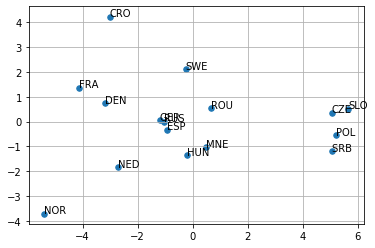

In [100]:
plt.scatter(teams_df['PC1'], teams_df['PC2'], s=30)

ax = plt.gca()
for i in range(0,len(teams_df)):
    ax.annotate(teams_df.iloc[i,:]['Team'], (X_pca[i,0], X_pca[i,1]))

plt.grid()
plt.show()

In [101]:
pd.DataFrame(
    np.matrix.transpose(estimator.components_),
    columns=[f'PC-{i+1}' for i in range(X_pca.shape[1])],
    index=X.columns)

,PC-1,PC-2
7mPGoals,-0.245016,-0.217078
7mPMissed,-0.172319,0.148762
6mCGoals,-0.235173,0.202107
6mCMissed,-0.202380,0.141850
WingGoals,-0.239237,-0.088239
WingMissed,-0.223994,-0.150411
BTGoals,-0.222730,-0.189488
BTMissed,-0.151207,-0.370648
FBGoals,-0.238785,-0.258327
FBMissed,-0.227995,-0.232130


# Clustering Expectation-Maximization

In [107]:
from sklearn.mixture import GaussianMixture

X = teams_df[['PC1', 'PC2']]

cv_types = ['spherical', 'tied', 'diag', 'full']
n_components_range = range(1, 10)

BIC = []
lowest_bic = np.infty
best_cv = 'full'
best_k = -1

for cv_type in cv_types:
    for k in n_components_range:
        EM = GaussianMixture(n_components=k, covariance_type=cv_type, init_params='random')
        EM.fit(X)
        
        BIC.append(EM.bic(X))
        
        if BIC[-1] < lowest_bic:
            lowest_bic = BIC[-1]
            best_cv = cv_type
            best_k = k
            
print("Mejor valor K:", best_k)
print("Mejor tipo de Covarianza:", best_cv)

Mejor valor K: 8
Mejor tipo de Covarianza: full


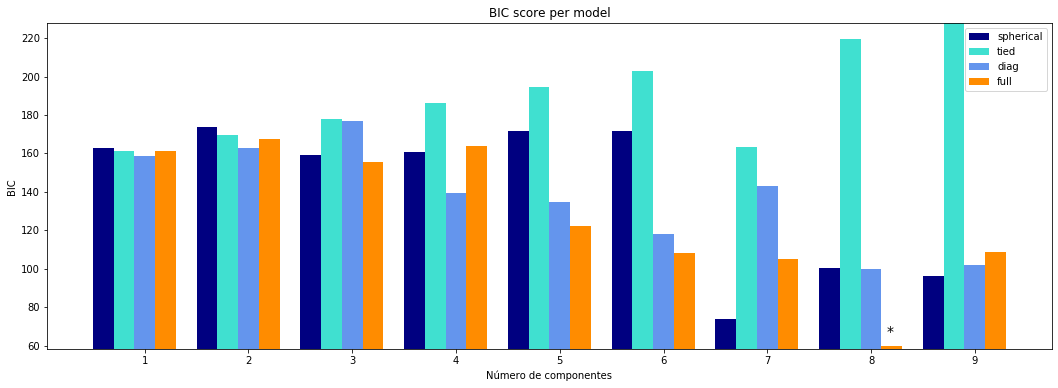

In [108]:
import itertools
import matplotlib.pyplot as plt

color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue', 'darkorange'])

plt.figure(figsize=(18, 6))
bars = []
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos,
                        BIC[i * len(n_components_range):(i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([min(BIC) * 1.01 - .01 * max(BIC), max(BIC)])

plt.title('BIC score per model')
plt.xlabel('Número de componentes')
plt.ylabel('BIC')
plt.legend([b[0] for b in bars], cv_types)

xpos = np.mod(np.argmin(BIC), len(n_components_range)) + .55 + .2 * np.floor(np.argmin(BIC) / len(n_components_range))
plt.text(xpos, min(BIC) * 0.97 + .03 * max(BIC), '*', fontsize=14)

plt.show()

Ocurre algo similar a cuando se han usado las variables Goals y Shots. Este algoritmo tiende al sobreaprendizaje y, al haber tan pocos puntos (16), intenta agrupar de manera muy granularizada.

Para evitar que la inicialización aleatoria dé problemas (con pocos puntos puede quedarse en un mínimo local muy fácilmente), vamos a utilizar la inicialización con K-Means.

In [166]:
print(f"Expectation-Maximization with K={best_k} and covariance '{best_cv}'")
EM = GaussianMixture(n_components=best_k, covariance_type=best_cv, init_params='kmeans')
EM.fit(X)
labels =  EM.predict(X)

Expectation-Maximization with K=8 and covariance 'full'


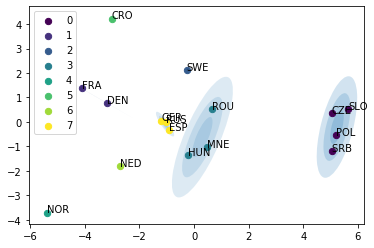

In [168]:
plot_EM(EM, teams_df[['PC1', 'PC2']], labels=labels)
#plot_EM(EM, teams_df[['PC1', 'PC2']], labels=labels, out='../figures/Hito2_EM-auto.pdf')

Como se puede ver, ha agrupado simplemente los puntos que están muy muy cerca entre sí.

Vamos a intentar ajustar la parametrización manualmente. Tras varias pruebas, hemos decidido utilizar un K de 5 y una covarianza de tipo 'full'.

In [173]:
EM = GaussianMixture(n_components=5, covariance_type='full', init_params='kmeans')
EM.fit(X)
labels =  EM.predict(X)

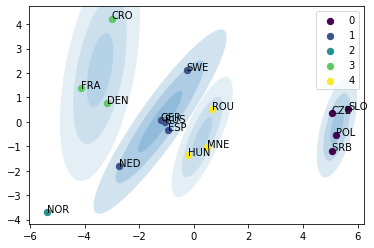

In [176]:
plot_EM(EM, teams_df[['PC1', 'PC2']], labels=labels)
#plot_EM(EM, teams_df[['PC1', 'PC2']], labels=labels, out='../figures/Hito2_EM-manual.pdf')

In [177]:
# Añadimos el cluster obtenido como un dato más
teams_df['cluster'] = labels

teams_df.to_csv('../models/teams_EM.csv')

In [178]:
grouped_teams = teams_df[['Team', 'cluster']].groupby('cluster')['Team'].apply(list)
grouped_teams

cluster
0        [CZE, POL, SLO, SRB ]
1    [ESP, GER, NED, RUS, SWE]
2                        [NOR]
3              [CRO, DEN, FRA]
4              [HUN, MNE, ROU]
Name: Team, dtype: object

# Caracterización de los clústers

,7mPGoals,7mPMissed,6mCGoals,6mCMissed,WingGoals,WingMissed,BTGoals,BTMissed,FBGoals,FBMissed,FTOGoals,FTOMissed,9mGoals,9mMissed,RC,2M,AS,R7,ST,BS,P7,TO
cluster,,,,,,,,,,,,,,,,,,,,,,
0,8.0,4.000000,9.75,5.000000,21.250000,14.75,5.250000,3.250000,5.250000,2.500000,0.000000,0.000000,20.500000,33.000000,0.0,10.250000,32.000000,12.000000,11.750000,4.750000,13.500000,38.000000
1,19.0,8.600000,27.80,11.000000,45.400000,34.60,17.000000,10.000000,18.400000,8.000000,0.200000,1.200000,37.400000,58.400000,0.2,23.800000,84.000000,27.600000,26.400000,11.600000,25.800000,81.800000
2,35.0,9.000000,36.00,14.000000,59.000000,40.00,44.000000,15.000000,47.000000,18.000000,0.000000,0.000000,33.000000,50.000000,0.0,18.000000,148.000000,44.000000,34.000000,33.000000,24.000000,75.000000
3,19.0,8.333333,36.00,17.000000,57.333333,35.00,19.333333,4.333333,23.333333,8.666667,1.000000,0.000000,47.666667,67.666667,1.0,26.333333,93.333333,28.000000,42.333333,21.333333,36.000000,92.666667
4,17.0,5.000000,23.00,7.666667,40.000000,39.00,13.666667,8.333333,16.666667,8.000000,0.333333,1.333333,35.666667,57.000000,0.0,15.666667,76.333333,22.333333,20.333333,8.666667,21.666667,82.666667


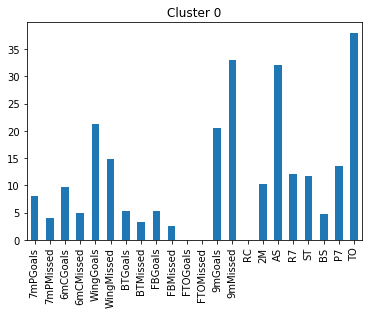

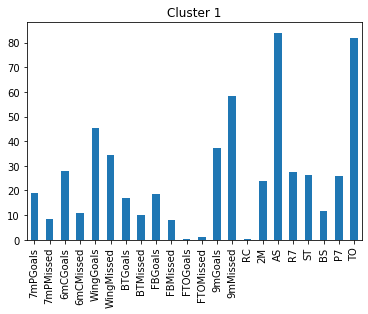

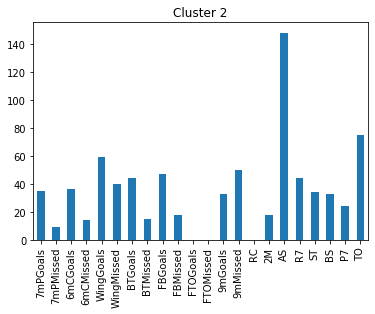

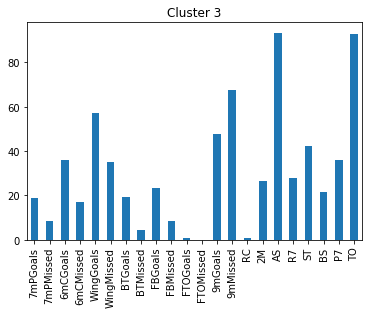

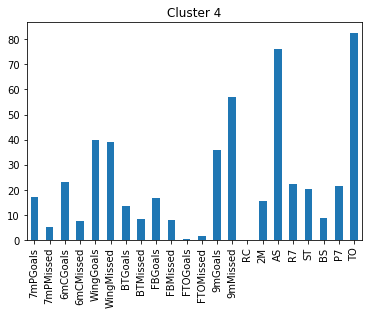

In [179]:
# Calculamos la media de todas las variables agrupando por cluster
mean_df = teams_df[['cluster','7mPGoals','7mPMissed','6mCGoals','6mCMissed','WingGoals','WingMissed','BTGoals','BTMissed','FBGoals','FBMissed','FTOGoals','FTOMissed','9mGoals','9mMissed','RC','2M','AS','R7','ST','BS','P7','TO']]\
                .groupby('cluster').mean()

# Dibujamos los valores medios de las variables en cada cluster
N = len(mean_df)
for cluster_index in range(N):
    plt.figure()
    plt.title(f'Cluster {cluster_index}')
    mean_df.iloc[cluster_index].plot.bar(legend=False)
    plt.savefig(f'../figures/Hito2_EM-cluster-{cluster_index}')

mean_df